# Graph Embedding with Color Refinement

This is a technique used to embed graphs into a feature space such that it preserves the count of  identical subgraphs between graphs with a 0% false negative rate and arbitrarily close to 0% false positive rate. 
 
This is useful for graph prediction tasks where the relevant features are identical subgraphs. The odds of a false postive increases with the size of the subgraphs.
 
This graph embedding algorithm + a Weighted Ensemble of LGBM models I  used to get first place in a [Molecule Classification competition hosted by the Therapeutic Data Commons](https://tdcommons.ai/benchmark/admet_group/10cyp2c9i/)
 
Primarily based on this lecture:
 
Stanford Online, Professor Jure Leskovec
[CS224W: Machine Learning with Graphs | 2021 | Lecture 2.3 - Traditional Feature-based Methods: Graph](https://www.youtube.com/watch?v=buzsHTa4Hgs&t=701s)
 
 
[Source Code for ColorRefinment](https://github.com/parkerburchett/TDC-DeepLearning/blob/main/utils/ColorRefinement.py)
 



In [8]:
import ColorRefinement as cr
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from pysmiles import read_smiles

In [9]:
def compute_mol_only_elements(smile):
    mol = read_smiles(smile)
    unique_elements = set()
    for n in mol.nodes:
        del mol.nodes[n]['charge']
        del mol.nodes[n]['hcount']
        del mol.nodes[n]['aromatic']
        try:
            del mol.nodes[n]['stereo']
        except:
            pass
    return mol

def show_mol_only_elements(mol):
    labels = nx.get_node_attributes(mol, 'element')
    plt.figure(figsize=(4,4)) 
    nx.draw_kamada_kawai(mol,labels=labels,node_size=1500, font_size=20)
    plt.show()


Two subgraphs with identical topology that are chemically distinct. In order to capture these differences the initial node color is set as a hash of node attributes.
 

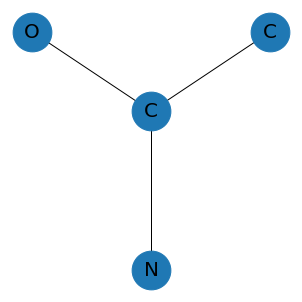

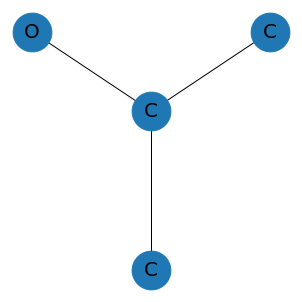

In [10]:
a ='CC(=O)N'
mol = compute_mol_only_elements(a)
show_mol_only_elements(mol)
b ='CC(=O)C'
mol = compute_mol_only_elements(b)
show_mol_only_elements(mol)

Atom "[C@@]" contains stereochemical information that will be discarded.


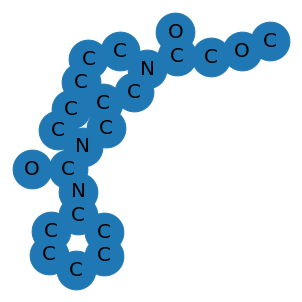

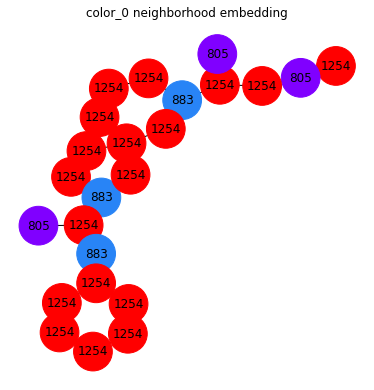

In [14]:
mol_1 = compute_mol_only_elements('COCC(=O)N1CCC[C@@]2(CCN(C(=O)Nc3ccccc3)C2)C1')
mol_2 = compute_mol_only_elements('COC(=O)N1CCC2(CCCN(C(=O)Nc3ccccc3)C2)CC1')

show_mol_only_elements(mol_1)
color_graph = cr._compute_K_color_refinements(G=mol_1,K=5, num_buckets=3000)
render_color_graph(color_graph, 'color_0')
color_graph

# Color Refinement

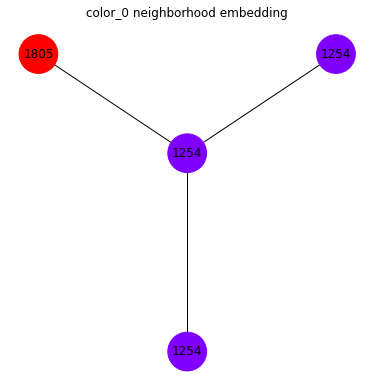

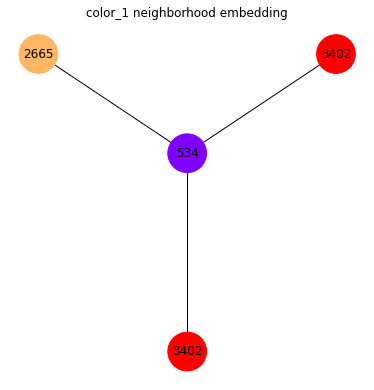

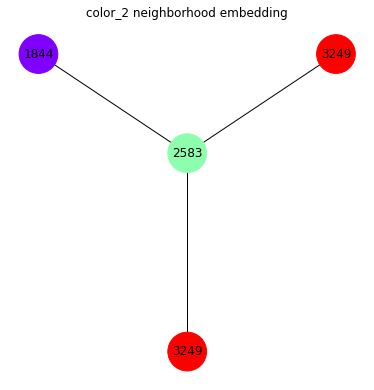

In [15]:
def render_color_graph(color_graph, color_number):
    labels = nx.get_node_attributes(color_graph, color_number)
    color_df = pd.DataFrame.from_dict(labels.items())
    color_df.columns = ['ID', 'COLOR']
    color_df
    plt.figure(figsize=(5,5)) 
    nx.draw_kamada_kawai(color_graph,
                        labels=labels,
                        node_size=1500,node_color=color_df['COLOR'],
                        cmap=plt.cm.rainbow)
    plt.title(f'{color_number} neighborhood embedding')
    plt.show()
color_graph = cr._compute_K_color_refinements(G=mol,K=5, num_buckets=5000)
render_color_graph(color_graph, 'color_0')
render_color_graph(color_graph, 'color_1')
render_color_graph(color_graph, 'color_2')

## Larger and Similar molecules

Atom "[C@@]" contains stereochemical information that will be discarded.


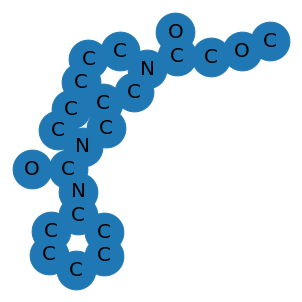

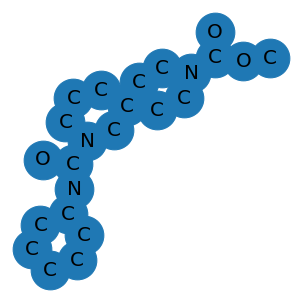

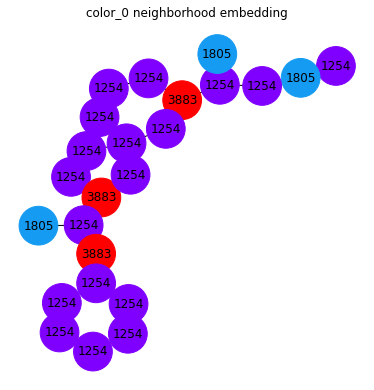

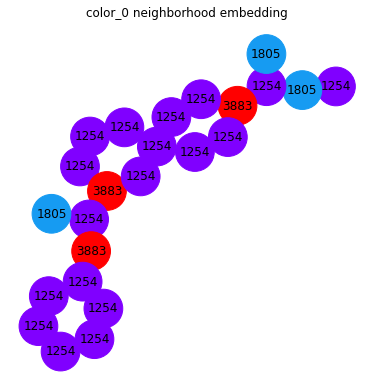

In [16]:
mol_1 = compute_mol_only_elements('COCC(=O)N1CCC[C@@]2(CCN(C(=O)Nc3ccccc3)C2)C1')
mol_2 = compute_mol_only_elements('COC(=O)N1CCC2(CCCN(C(=O)Nc3ccccc3)C2)CC1')


show_mol_only_elements(mol_1)
show_mol_only_elements(mol_2)



mol_1_color_graph = cr._compute_K_color_refinements(mol_1,5, 5000)
mol_2_color_graph = cr._compute_K_color_refinements(mol_2,5, 5000)
render_color_graph(mol_1_color_graph, 'color_0')
render_color_graph(mol_2_color_graph, 'color_0')

mol_2_color_graph

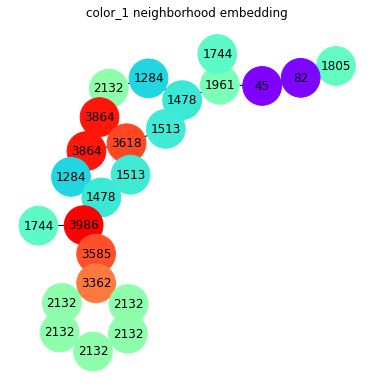

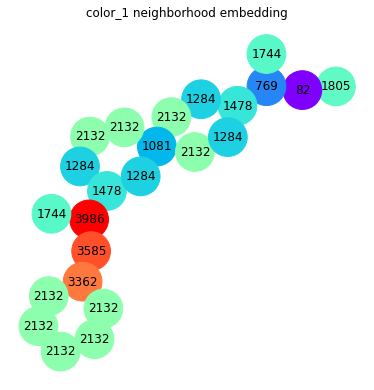

In [7]:
render_color_graph(mol_1_color_graph, 'color_1')
render_color_graph(mol_2_color_graph, 'color_1')

You can still see how similar these molecules are after 1 hop.

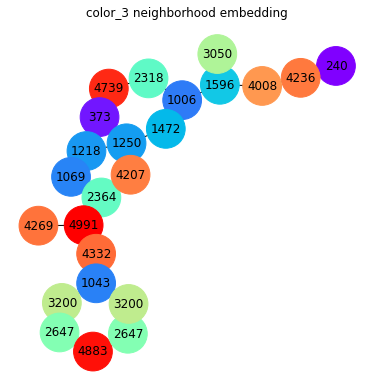

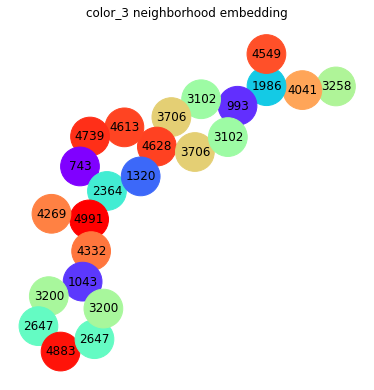

In [38]:
render_color_graph(mol_1_color_graph, 'color_3')
render_color_graph(mol_2_color_graph, 'color_3')

Even at the 4th hop the molecules are still similar, This is because the subgraphs of size 4 starting at the bottom left section are identical. The other subgraphs diverge into different colors 

In [17]:
graph_node_colors = cr._compute_node_colors(mol,3,5000)
print('0 hop')
print(graph_node_colors.iloc[0].value_counts())
# there are no nodes that have the same 2 hop neighborhood
print('1 hop')
print(graph_node_colors.iloc[1].value_counts())
print('2 hop')
print(graph_node_colors.iloc[2].value_counts())
graph_node_colors

0 hop
1254    3
1805    1
Name: color_0, dtype: int64
1 hop
3402    2
534     1
2665    1
Name: color_1, dtype: int64
2 hop
3249    2
2583    1
1844    1
Name: color_2, dtype: int64


,Node_0,Node_1,Node_2,Node_3
iteration_number,,,,
color_0,1254,1254,1805,1254
color_1,3402,534,2665,3402
color_2,3249,2583,1844,3249


In [24]:
seq = 'EVQLQQSGAEVVRSGASVKLSCTASGFNIKDYYIHWVKQRPEKGLEWIGWIDPEIGDTEYVPKFQGKATMTADTSSNTAYLQLSSLTSEDTAVYYCNAGHDYDRGRFPYWGQGTLVTVSA'
# https://www.novoprolabs.com/tools/convert-peptide-to-smiles-string
a = 'N[C@@]([H])(CCC(=O)O)C(=O)N[C@@]([H])(C(C)C)C(=O)N[C@@]([H])(CCC(=O)N)C(=O)N[C@@]([H])(CC(C)C)C(=O)N[C@@]([H])(CCC(=O)N)C(=O)N[C@@]([H])(CCC(=O)N)C(=O)N[C@@]([H])(CO)C(=O)NCC(=O)N[C@@]([H])(C)C(=O)N[C@@]([H])(CCC(=O)O)C(=O)N[C@@]([H])(C(C)C)C(=O)N[C@@]([H])(C(C)C)C(=O)N[C@@]([H])(CCCNC(=N)N)C(=O)N[C@@]([H])(CO)C(=O)NCC(=O)N[C@@]([H])(C)C(=O)N[C@@]([H])(CO)C(=O)N[C@@]([H])(C(C)C)C(=O)N[C@@]([H])(CCCCN)C(=O)N[C@@]([H])(CC(C)C)C(=O)N[C@@]([H])(CO)C(=O)N[C@@]([H])(CS)C(=O)N[C@@]([H])([C@]([H])(O)C)C(=O)N[C@@]([H])(C)C(=O)N[C@@]([H])(CO)C(=O)NCC(=O)N[C@@]([H])(Cc1ccccc1)C(=O)N[C@@]([H])(CC(=O)N)C(=O)N[C@@]([H])([C@]([H])(CC)C)C(=O)N[C@@]([H])(CCCCN)C(=O)N[C@@]([H])(CC(=O)O)C(=O)N[C@@]([H])(Cc1ccc(O)cc1)C(=O)N[C@@]([H])(Cc1ccc(O)cc1)C(=O)N[C@@]([H])([C@]([H])(CC)C)C(=O)N[C@@]([H])(CC1=CN=C-N1)C(=O)N[C@@]([H])(CC(=CN2)C1=C2C=CC=C1)C(=O)N[C@@]([H])(C(C)C)C(=O)N[C@@]([H])(CCCCN)C(=O)N[C@@]([H])(CCC(=O)N)C(=O)N[C@@]([H])(CCCNC(=N)N)C(=O)N1[C@@]([H])(CCC1)C(=O)N[C@@]([H])(CCC(=O)O)C(=O)N[C@@]([H])(CCCCN)C(=O)NCC(=O)N[C@@]([H])(CC(C)C)C(=O)N[C@@]([H])(CCC(=O)O)C(=O)N[C@@]([H])(CC(=CN2)C1=C2C=CC=C1)C(=O)N[C@@]([H])([C@]([H])(CC)C)C(=O)NCC(=O)N[C@@]([H])(CC(=CN2)C1=C2C=CC=C1)C(=O)N[C@@]([H])([C@]([H])(CC)C)C(=O)N[C@@]([H])(CC(=O)O)C(=O)N1[C@@]([H])(CCC1)C(=O)N[C@@]([H])(CCC(=O)O)C(=O)N[C@@]([H])([C@]([H])(CC)C)C(=O)NCC(=O)N[C@@]([H])(CC(=O)O)C(=O)N[C@@]([H])([C@]([H])(O)C)C(=O)N[C@@]([H])(CCC(=O)O)C(=O)N[C@@]([H])(Cc1ccc(O)cc1)C(=O)O'
mol = compute_mol_only_elements(a)
graph_node_colors = cr._compute_node_colors(mol,5,5000)
graph_node_colors

Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information that will be discarded.
Atom "[C@@]" contains stereochemical information th

KeyError: 2

In [37]:
import peptides
seqs = "EVQLQQSGAEVVRSGASVKLSCTASGFNIKDYYIHWVKQRPEKGLEWIGWIDPEIGDTEYVPKFQGKATMTADTSSNTAYLQLSSLTSEDTAVYYCNAGHDYDRGRFPYWGQGTLVTVSA"
print(len(seqs))
df = pd.DataFrame([ peptides.Peptide(s).descriptors() for s in seqs ])
df

120


,BLOSUM1,BLOSUM2,BLOSUM3,BLOSUM4,BLOSUM5,BLOSUM6,BLOSUM7,BLOSUM8,BLOSUM9,BLOSUM10,...,VHSE4,VHSE5,VHSE6,VHSE7,VHSE8,Z1,Z2,Z3,Z4,Z5
0,1.48,0.23,-0.67,-0.36,-0.28,-0.08,-1.01,0.36,0.77,0.30,...,0.36,-2.16,-0.17,0.91,0.02,3.11,0.26,-0.11,-3.04,-0.25
1,-1.13,-1.23,-0.63,0.06,-0.60,0.16,0.01,0.02,0.25,0.61,...,-1.91,0.22,-1.40,-0.24,-0.03,-2.59,-2.64,-1.54,-0.85,-0.02
2,1.09,0.30,-0.87,-0.72,0.50,-0.08,-0.44,0.20,0.38,0.67,...,0.16,0.09,0.42,-0.20,-0.41,1.75,0.50,-1.44,-1.34,0.66
3,-1.41,-0.86,-0.88,-0.17,0.03,0.34,0.11,0.15,-0.44,-0.02,...,-0.80,0.22,-1.37,0.08,-0.62,-4.28,-1.30,-1.49,-0.72,0.84
4,1.09,0.30,-0.87,-0.72,0.50,-0.08,-0.44,0.20,0.38,0.67,...,0.16,0.09,0.42,-0.20,-0.41,1.75,0.50,-1.44,-1.34,0.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,-1.13,-1.23,-0.63,0.06,-0.60,0.16,0.01,0.02,0.25,0.61,...,-1.91,0.22,-1.40,-0.24,-0.03,-2.59,-2.64,-1.54,-0.85,-0.02
116,0.19,-0.73,0.18,-0.01,0.02,0.38,-0.30,-1.96,0.15,0.06,...,-1.06,-0.06,-0.01,-0.79,0.39,0.75,-2.18,-1.12,-1.46,-0.40
117,-1.13,-1.23,-0.63,0.06,-0.60,0.16,0.01,0.02,0.25,0.61,...,-1.91,0.22,-1.40,-0.24,-0.03,-2.59,-2.64,-1.54,-0.85,-0.02
118,0.84,-0.45,0.42,0.32,0.20,0.54,0.01,-0.80,0.62,-0.13,...,-0.41,-0.32,0.27,-0.64,0.11,2.39,-1.07,1.15,-1.39,0.67


In [32]:
df.columns

Index(['BLOSUM1', 'BLOSUM2', 'BLOSUM3', 'BLOSUM4', 'BLOSUM5', 'BLOSUM6',
       'BLOSUM7', 'BLOSUM8', 'BLOSUM9', 'BLOSUM10', 'PP1', 'PP2', 'PP3', 'F1',
       'F2', 'F3', 'F4', 'F5', 'F6', 'KF1', 'KF2', 'KF3', 'KF4', 'KF5', 'KF6',
       'KF7', 'KF8', 'KF9', 'KF10', 'MSWHIM1', 'MSWHIM2', 'MSWHIM3', 'E1',
       'E2', 'E3', 'E4', 'E5', 'ProtFP1', 'ProtFP2', 'ProtFP3', 'ProtFP4',
       'ProtFP5', 'ProtFP6', 'ProtFP7', 'ProtFP8', 'SV1', 'SV2', 'SV3', 'SV4',
       'ST1', 'ST2', 'ST3', 'ST4', 'ST5', 'ST6', 'ST7', 'ST8', 'T1', 'T2',
       'T3', 'T4', 'T5', 'VHSE1', 'VHSE2', 'VHSE3', 'VHSE4', 'VHSE5', 'VHSE6',
       'VHSE7', 'VHSE8', 'Z1', 'Z2', 'Z3', 'Z4', 'Z5'],
      dtype='object')